In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from gym.envs.classic_control import PendulumEnv

from forward_models.model import Normalizer, ForwardModel
from forward_models.rollout import Rollout

In [3]:
sns.set_style('white')
sns.set_context('notebook')

In [4]:
tf.enable_eager_execution()

In [5]:
job_dir = '/Users/fomoro/jobs/forward_models/1543205667'
max_steps = 200
episodes = 4

In [6]:
env = PendulumEnv()

rollout = Rollout(env, max_steps=max_steps)

states, actions, rewards, next_states, weights = rollout(
     lambda state: env.action_space.sample(),
     episodes=episodes)

deltas = next_states - states

state_normalizer = Normalizer(
    loc=states.mean(axis=(0, 1)),
    scale=states.std(axis=(0, 1)))
delta_normalizer = Normalizer(
    loc=deltas.mean(axis=(0, 1)),
    scale=deltas.std(axis=(0, 1)))
action_normalizer = Normalizer(
    loc=actions.mean(axis=(0, 1)),
    scale=actions.std(axis=(0, 1)))

model = ForwardModel(output_units=env.observation_space.shape[-1])

checkpoint = tf.train.Checkpoint(
    state_normalizer=state_normalizer,
    delta_normalizer=delta_normalizer,
    action_normalizer=action_normalizer,
    model=model)
checkpoint_path = tf.train.latest_checkpoint(job_dir)
assert checkpoint_path is not None, 'job_dir must contain checkpoint'
checkpoint.restore(checkpoint_path)

# Instantaneous Evaluation

In [7]:
states_norm = state_normalizer(states)
actions_norm = action_normalizer(actions)
deltas_norm_pred = model(states_norm, actions_norm, training=False, reset_state=True)
deltas_pred = delta_normalizer.invert(deltas_norm_pred)
next_states_pred = states + deltas_pred.numpy()

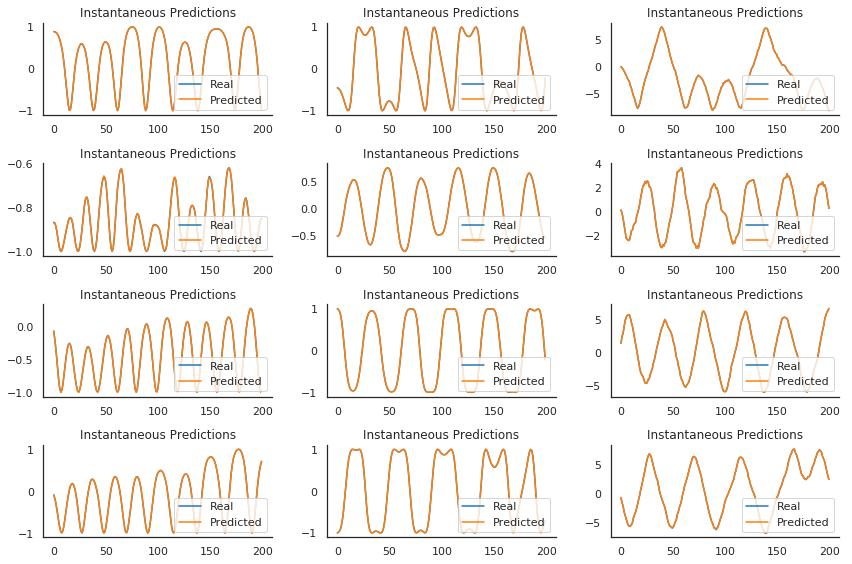

In [8]:
state_size = env.observation_space.shape[-1]
fig, axes = plt.subplots(episodes, state_size, figsize=(12, 8))
for episode in range(episodes):
    for state_dim in range(state_size):
        ax = axes[episode, state_dim]
        ax.plot(next_states[episode, :, state_dim], label='Real')
        ax.plot(next_states_pred[episode, :, state_dim], label='Predicted')
        ax.legend(loc='lower right')
        ax.set_title('Instantaneous Predictions')
sns.despine()
plt.tight_layout()

# Rollout Evaluation

In [9]:
curr_state = states[:, 0][:, None]
curr_action = actions[:, 0][:, None]

next_states_pred_list = []
for step in range(max_steps):
    curr_state_norm = state_normalizer(curr_state)
    curr_action_norm = action_normalizer(curr_action)
    reset_state = (step == 0)
    curr_delta_norm_pred = model(
        curr_state_norm,
        curr_action_norm,
        training=False,
        reset_state=reset_state)
    curr_delta_pred = delta_normalizer.invert(curr_delta_norm_pred)
    curr_pred = curr_delta_pred + curr_state
    next_states_pred_list.append(curr_pred.numpy())

    curr_state = curr_pred
    curr_action = actions[:, step][:, None]

next_states_pred = np.concatenate(next_states_pred_list, axis=1)
next_states_pred.shape

(4, 200, 3)

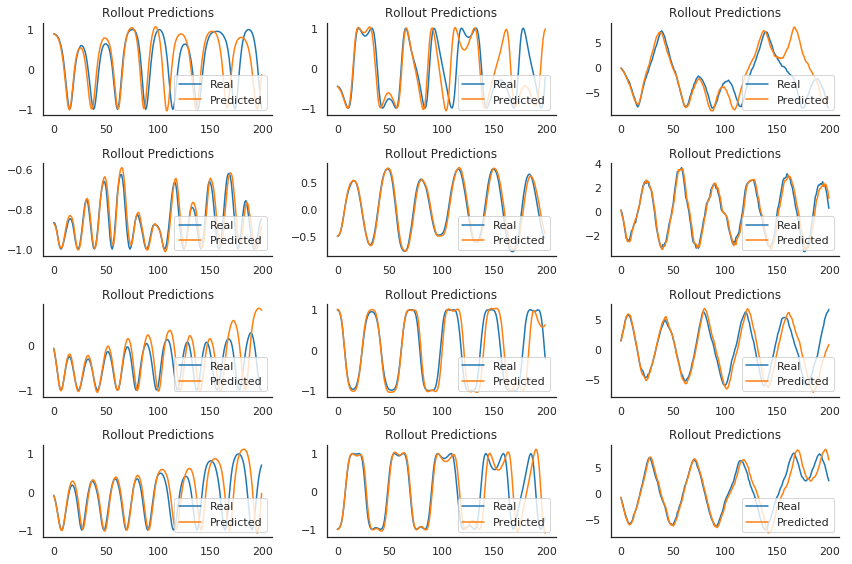

In [10]:
state_size = env.observation_space.shape[-1]
fig, axes = plt.subplots(episodes, state_size, figsize=(12, 8))
for episode in range(episodes):
    for state_dim in range(state_size):
        ax = axes[episode, state_dim]
        ax.plot(next_states[episode, :, state_dim], label='Real')
        ax.plot(next_states_pred[episode, :, state_dim], label='Predicted')
        ax.legend(loc='lower right')
        ax.set_title('Rollout Predictions')
sns.despine()
plt.tight_layout()